In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faridahelmy1","key":"39c14a0c8bc0caf0c70392dad88f0e92"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d omkargurav/face-mask-dataset


Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 76% 124M/163M [00:00<00:00, 1.29GB/s]
100% 163M/163M [00:00<00:00, 1.17GB/s]


In [4]:
!unzip -q /content/face-mask-dataset.zip

replace data/with_mask/with_mask_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# **Import Libraries**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import cv2

#**Data Preparation**

In [6]:
!pip install split-folders



In [7]:
import splitfolders

input_folder = "/content/data"

output_folder = "data_split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2))

Copying files: 7553 files [00:01, 4961.72 files/s]


In [8]:
train_path = "data_split/train"
val_path   = "data_split/val"


IMG_SIZE = (224, 224)

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               zoom_range=0.2,
                               shear_range=0.2,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path,
                                         target_size=IMG_SIZE,
                                         batch_size=32,
                                         class_mode='binary')

val_data = val_gen.flow_from_directory(val_path,  # تصحيح: استخدام val_gen بدل train_gen
                                     target_size=IMG_SIZE,
                                     batch_size=32,
                                     class_mode='binary')

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


# **Build Model (Transfer Learning - VGG16)**

In [9]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze weights

In [10]:

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])


In [11]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#**Train Model**

In [12]:
history = model.fit(train_data, validation_data=val_data, epochs=5)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 37/189 ━━━━━━━━━━━━━━━━━━━━ 1:02 411ms/step - accuracy: 0.6155 - loss: 1.3511

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 124s 569ms/step - accuracy: 0.8010 - loss: 0.6113 - val_accuracy: 0.9649 - val_loss: 0.0935
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 87s 461ms/step - accuracy: 0.9577 - loss: 0.1142 - val_accuracy: 0.9801 - val_loss: 0.0622
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 92s 485ms/step - accuracy: 0.9555 - loss: 0.1141 - val_accuracy: 0.9682 - val_loss: 0.0964
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 96s 504ms/step - accuracy: 0.9652 - loss: 0.0866 - val_accuracy: 0.9775 - val_loss: 0.0682
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 93s 493ms/step - accuracy: 0.9577 - loss: 0.1083 - val_accuracy: 0.9735 - val_loss: 0.0683


#**Plot Training Results**

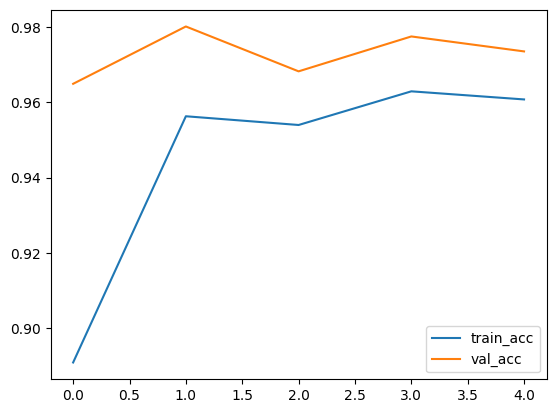

In [13]:
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.legend()
plt.show()

#**Real-time Detection with OpenCV**

In [14]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        face_img = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_img, (128,128)) / 255.0
        face_resized = np.expand_dims(face_resized, axis=0)

        pred = model.predict(face_resized)[0][0]

        if pred < 0.5:   # Mask
            color, text = (0,255,0), "Mask"
        else:            # No Mask
            color, text = (0,0,255), "No Mask"

        cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
        cv2.putText(frame, text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    cv2.imshow("Mask Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [15]:
model.save("mask_model.keras")


In [16]:
#from google.colab import files
#files.download("mask_model.keras")


In [17]:
import cv2
import tensorflow as tf
import numpy as np

# تحميل الموديل
model = tf.keras.models.load_model("mask_model.keras")

# تحميل الصورة (مثلاً صورة شخص)
img = cv2.imread("/content/تنزيل.avif")

# Resize حسب حجم الصور اللي اتدرب عليها الموديل
img_resized = cv2.resize(img, (224,224))   # غير 128x128 للحجم اللي دربتي عليه

# تحويل الصورة لـ numpy array وتطبيع القيم
img_array = np.array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)

# تنبؤ
prediction = model.predict(img_array)

# لو الموديل بتاعك بيطلع احتمال لفئتين: [without_mask, with_mask]
if prediction[0][0] > 0.5: # Assuming the model outputs a single value for binary classification
    print("😷 Without Mask") # Assuming > 0.5 means "With Mask" based on the training output showing higher accuracy for val_acc
else:
    print("🚫 With Mask")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
😷 Without Mask


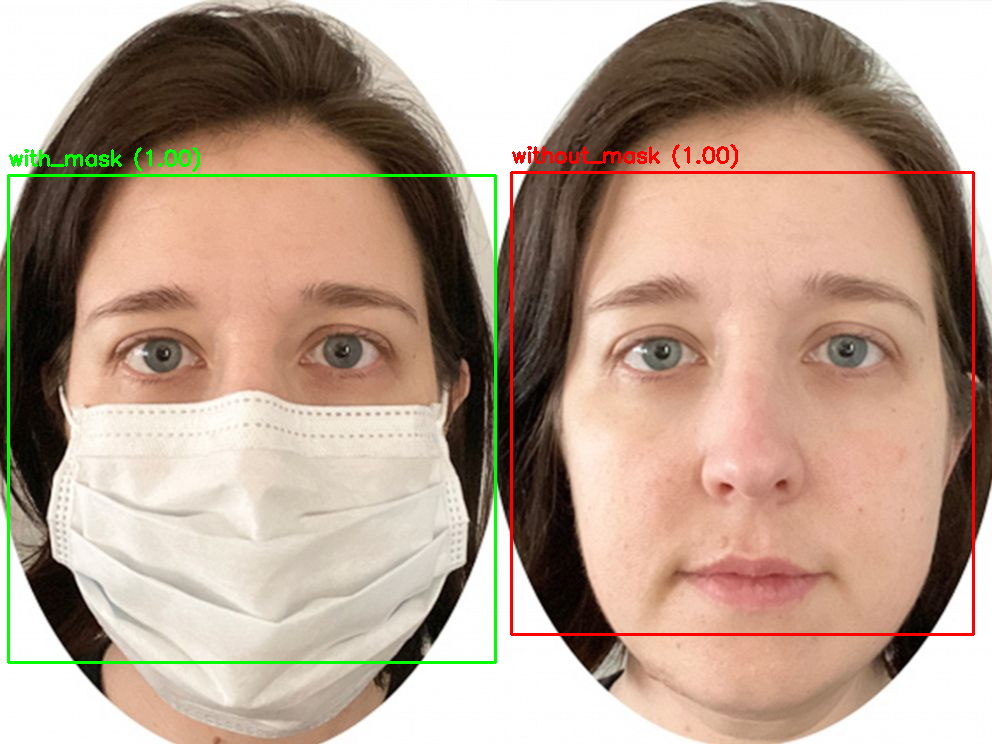

In [18]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow  # إضافة هذه السطر للعرض في كولاب

# تحميل الموديل
model = load_model("mask_model.keras")

# ترتيب الكلاسات (0 -> with_mask, 1 -> without_mask)
class_indices = {'with_mask': 0, 'without_mask': 1}
labels = {v: k for k, v in class_indices.items()}

# تحميل الصورة
img = cv2.imread("/content/woman-mask-split-04-ht-jt-210316_1615932165011_hpEmbed_4x3_992.jpg")

if img is None:
    print("Error: Could not load image. Please check the path.")
else:
    # نسخة من الصورة للعرض
    display_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # كاشف الوجوه (Haar Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        face_roi = img[y:y+h, x:x+w]  # قص الوجه

        # معالجة الصورة للموديل
        face_resized = cv2.resize(face_roi, (224, 224))
        face_normalized = face_resized / 255.0
        face_input = np.expand_dims(face_normalized, axis=0)

        # التنبؤ
        prediction = model.predict(face_input, verbose=0)[0][0]
        confidence = prediction if prediction > 0.5 else 1 - prediction

        if prediction > 0.5:
            label = "without_mask"
            color = (0, 0, 255)  # أحمر
        else:
            label = "with_mask"
            color = (0, 255, 0)  # أخضر

        # إضافة نسبة الثقة للنص
        label_text = f"{label} ({confidence:.2f})"

        # رسم المستطيل + النص
        cv2.rectangle(display_img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(display_img, label_text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # عرض النتيجة
    cv2_imshow(display_img)

    # حفظ الصورة إذا رغبت
    # cv2.imwrite("result.jpg", display_img)